# CONEXIÓN a API DE BLUESKY

In [43]:
import requests

url = "https://bsky.social/xrpc/app.bsky.feed.getAuthorFeed"

url_se = "https://bsky.social/xrpc/com.atproto.server.createSession"
payload = {
  "identifier": "grupo18.bsky.social",
  "password":'Grupo18*BS'
}
response_tk = requests.post(url_se, json=payload)
response_tk.raise_for_status()
token = response_tk.json()["accessJwt"]  # Token de acceso


## Búsqueda de actores por palabras clave

In [52]:
# --- Celda 2: Búsqueda de Múltiples Actores ---
import requests
import pandas as pd

# Lista de términos de búsqueda para los actores
''' search_terms = ["elpais", "bloomberg", "reuters", "apnews", "aoc", "theguardian", "washingtonpost", "nytimes", 
                "economist", "eldiario", "elpais", "lavanguardia", 
                "infobae", "lanacion", "clarin", "barchart", "wired", "unusualwhales"] # Ejemplo: Puedes cambiar esta lista'''

# Lista de términos de búsqueda para los actores
search_terms = ["bloomberg", "aoc", "economist"]

# URL del endpoint de búsqueda de actores
search_url = "https://bsky.social/xrpc/app.bsky.actor.searchActors"

# Headers con el token de autenticación (Asegúrate que 'token' existe de la celda 1)
headers = {
    "Authorization": f"Bearer {token}"
}

found_actors = []
# ----- AQUÍ SE DECLARA LA LISTA VACÍA -----
actor_handles = []

print("Buscando actores...")
for term in search_terms:
    print(f"- Buscando '{term}'...")
    params = {
        "term": term,
        "limit": 1 # Buscamos solo el resultado más relevante por término
    }
    try:
        response = requests.get(search_url, headers=headers, params=params)
        response.raise_for_status()
        search_data = response.json()

        if search_data['actors']:
            actor = search_data['actors'][0] # Tomamos el primer resultado
            print(f"  Encontrado: {actor['handle']} ({actor.get('displayName', 'N/A')})")
            actor_info = {
                'search_term': term,
                'did': actor['did'],
                'handle': actor['handle'],
                'display_name': actor.get('displayName', ''),
                'description': actor.get('description', ''),
            }
            found_actors.append(actor_info)
            # ----- AQUÍ SE LLENA LA LISTA -----
            actor_handles.append(actor['handle'])
        else:
            print(f"  No se encontraron resultados para '{term}'.")

    except requests.exceptions.RequestException as e:
        print(f"  Error buscando '{term}': {e}")

# Crear y mostrar DataFrame de actores encontrados
if found_actors:
    df_found_actors = pd.DataFrame(found_actors)
    print("\nActores encontrados:")
    display(df_found_actors[['search_term', 'handle', 'display_name']])
else:
    print("\nNo se encontraron actores para los términos de búsqueda.")

# Eliminar duplicados si los hubiera
actor_handles = list(set(actor_handles))
print(f"\nHandles únicos a procesar: {actor_handles}") # Esta lista se usará en la siguiente celda

Buscando actores...
- Buscando 'bloomberg'...
  Encontrado: bloomberg.com (Bloomberg News)
- Buscando 'aoc'...
  Encontrado: aoc.bsky.social (Alexandria Ocasio-Cortez)
- Buscando 'economist'...
  Encontrado: quinnypig.com (Corey Quinn)

Actores encontrados:


,search_term,handle,display_name
0,bloomberg,bloomberg.com,Bloomberg News
1,aoc,aoc.bsky.social,Alexandria Ocasio-Cortez
2,economist,quinnypig.com,Corey Quinn



Handles únicos a procesar: ['bloomberg.com', 'quinnypig.com', 'aoc.bsky.social']


In [53]:
# --- Celda 3: Obtención de Feeds de Múltiples Actores ---
import pandas as pd
from datetime import datetime

# URL del endpoint para obtener feed
feed_url = "https://bsky.social/xrpc/app.bsky.feed.getAuthorFeed"

# Límite de posts por actor
posts_limit_per_actor = 100 # Puedes ajustar este número

all_posts = []

print(f"\nObteniendo feeds para {len(actor_handles)} actores (límite {posts_limit_per_actor} posts por actor)...")

if not actor_handles:
    print("No hay handles de actores para obtener feeds.")
else:
    for handle in actor_handles:
        print(f"- Obteniendo feed de '{handle}'...")
        params = {
            "actor": handle,
            "limit": posts_limit_per_actor
        }
        try:
            response = requests.get(feed_url, headers=headers, params=params)
            response.raise_for_status()
            feed_data = response.json()

            for item in feed_data.get('feed', []):
                 # Asegurarse que el item tiene 'post' y 'record'
                post = item.get('post')
                if not post or 'record' not in post:
                    print(f"  Advertencia: Post incompleto en feed de {handle}, saltando.")
                    continue

                record = post.get('record', {})
                created_at_str = record.get('createdAt', '')
                created_at_dt = None
                if created_at_str:
                    try:
                        created_at_dt = datetime.fromisoformat(created_at_str.replace('Z', '+00:00'))
                    except ValueError:
                         print(f"  Advertencia: Formato de fecha inválido '{created_at_str}' en post de {handle}, saltando.")
                         continue


                post_data = {
                    'actor_handle': handle, # Agregamos el handle del actor
                    'uri': post.get('uri', ''),
                    'text': record.get('text', ''),
                    'created_at': created_at_dt,
                    'likes': post.get('likeCount', 0),
                    'reposts': post.get('repostCount', 0),
                    'replies': post.get('replyCount', 0)
                }
                # Filtrar posts sin fecha válida
                if post_data['created_at']:
                    all_posts.append(post_data)

        except requests.exceptions.RequestException as e:
            print(f"  Error obteniendo feed de '{handle}': {e}")
        except Exception as e:
            print(f"  Error procesando feed de '{handle}': {e}")


# Crear DataFrame combinado con todos los posts
if all_posts:
    df = pd.DataFrame(all_posts)
    # Asegurarse que 'created_at' es datetime
    df['created_at'] = pd.to_datetime(df['created_at'])
    # Ordenar por fecha descendente (opcional)
    df = df.sort_values(by='created_at', ascending=False).reset_index(drop=True)
    print("\nFeed combinado de todos los actores:")
    display(df[['actor_handle', 'created_at', 'text', 'likes', 'reposts']].head()) # Mostrar una vista previa
    print(f"\nTotal de posts obtenidos: {len(df)}")
else:
    print("\nNo se pudieron obtener posts de los actores.")
    # Crear un DataFrame vacío para evitar errores en celdas posteriores
    df = pd.DataFrame(columns=['actor_handle', 'uri', 'text', 'created_at', 'likes', 'reposts', 'replies'])



Obteniendo feeds para 3 actores (límite 100 posts por actor)...
- Obteniendo feed de 'bloomberg.com'...
- Obteniendo feed de 'quinnypig.com'...
- Obteniendo feed de 'aoc.bsky.social'...

Feed combinado de todos los actores:


,actor_handle,created_at,text,likes,reposts
0,bloomberg.com,2025-04-08 21:49:42.165000+00:00,new episode of Elon Inc. today! We discuss the...,47,12
1,bloomberg.com,2025-04-08 21:22:29.573000+00:00,"US equity futures rose, rebounding after volat...",25,5
2,quinnypig.com,2025-04-08 20:59:39.316000+00:00,On AWS there is no pricing difference. I can’t...,0,0
3,quinnypig.com,2025-04-08 20:33:43.019000+00:00,I can’t wait until whoever’s resisting it so t...,1,0
4,bloomberg.com,2025-04-08 19:40:53.337000+00:00,"📩 Coming soon: Go in-depth on Pointed, our wee...",7,0



Total de posts obtenidos: 299


## Query a la API con los actores seleccionados

In [54]:
# Define el rango de fechas deseado (¡Asegúrate que df y su columna created_at existen!)
# Puedes cambiar estas fechas según tus necesidades
start_date_str = '2025-03-01'
end_date_str = '2025-04-30' # Incluye este día

# Convertir las fechas de inicio y fin a objetos datetime timezone-aware (UTC)
# ya que la columna 'created_at' está en UTC (+00:00)
try:
    # Asegúrate que la columna 'created_at' es datetime y timezone-aware
    if not pd.api.types.is_datetime64_any_dtype(df['created_at']):
         df['created_at'] = pd.to_datetime(df['created_at'])
    if df['created_at'].dt.tz is None:
         # Si por alguna razón no es timezone-aware, la localizamos a UTC
         df['created_at'] = df['created_at'].dt.tz_localize('UTC')

    start_date = pd.to_datetime(start_date_str + ' 00:00:00+00:00')
    end_date = pd.to_datetime(end_date_str + ' 23:59:59+00:00')

    print(f"Filtrando posts entre {start_date_str} y {end_date_str}...")

    # Aplicar el filtro
    df_filtered = df[(df['created_at'] >= start_date) & (df['created_at'] <= end_date)].copy()

    print(f"Posts originales: {len(df)}")
    print(f"Posts después del filtro: {len(df_filtered)}")

    if not df_filtered.empty:
        print("\nVista previa de los posts filtrados:")
        display(df_filtered[['actor_handle', 'created_at', 'text']].head())
    else:
        print("\nNo se encontraron posts en el rango de fechas especificado.")

    # --- IMPORTANTE ---
    # A partir de aquí, si quieres que los análisis posteriores (sentimiento, frecuencia, etc.)
    # se realicen SOLO sobre los datos filtrados, debes usar df_filtered en lugar de df.
    # Por ejemplo, la siguiente celda de análisis de sentimiento debería empezar con:
    # daily_sentiment_df = analyze_sentiment_by_day(df_filtered)

except KeyError:
    print("Error: La columna 'created_at' no existe en el DataFrame 'df'. Asegúrate que la celda anterior se ejecutó correctamente.")
except Exception as e:
    print(f"Ocurrió un error durante el filtrado: {e}")
    # Si hay error, dejamos df_filtered como el df original para no romper el flujo
    df_filtered = df.copy()


Filtrando posts entre 2025-03-01 y 2025-04-30...
Posts originales: 299
Posts después del filtro: 258

Vista previa de los posts filtrados:


,actor_handle,created_at,text
0,bloomberg.com,2025-04-08 21:49:42.165000+00:00,new episode of Elon Inc. today! We discuss the...
1,bloomberg.com,2025-04-08 21:22:29.573000+00:00,"US equity futures rose, rebounding after volat..."
2,quinnypig.com,2025-04-08 20:59:39.316000+00:00,On AWS there is no pricing difference. I can’t...
3,quinnypig.com,2025-04-08 20:33:43.019000+00:00,I can’t wait until whoever’s resisting it so t...
4,bloomberg.com,2025-04-08 19:40:53.337000+00:00,"📩 Coming soon: Go in-depth on Pointed, our wee..."


## Transformar las salida de la API en un Panda

In [55]:
import pandas as pd
from datetime import datetime

# Crear DataFrame con los resultados
feed_data = response.json()
posts = []

for post in feed_data['feed']:
    post_data = {
        'uri': post['post']['uri'],
        'text': post['post']['record'].get('text', ''),
        'created_at': datetime.fromisoformat(post['post']['record']['createdAt'].replace('Z', '+00:00')),
        'likes': post['post']['likeCount'],
        'reposts': post['post']['repostCount'],
        'replies': post['post']['replyCount']
    }
    posts.append(post_data)

df = pd.DataFrame(posts)
print("\nFeed de unusualwhales.bsky.social:")
display(df)


Feed de unusualwhales.bsky.social:


,uri,text,created_at,likes,reposts,replies
0,at://did:plc:p7gxyfr5vii5ntpwo7f6dhe2/app.bsky...,ChatGPT ass presidency,2025-04-04 20:28:28.265000+00:00,23611,3877,647
1,at://did:plc:bono5gae7m6r3qpfxomshwbd/app.bsky...,"Pushback works, part gazillion:\n\n""Here are t...",2025-03-31 18:27:33.653000+00:00,29373,9596,906
2,at://did:plc:p2dcugajbtsn44h5n2kgt7ox/app.bsky...,going to start calling myself a centrist and t...,2025-03-31 12:37:11.069000+00:00,29359,3815,546
3,at://did:plc:k4kp7p2lfe2fz6z2u26yslv4/app.bsky...,@chrismurphyct.bsky.social and I walking into ...,2025-03-29 21:03:57.581000+00:00,10711,1659,290
4,at://did:plc:p7gxyfr5vii5ntpwo7f6dhe2/app.bsky...,We will not be distracted.\nWe will not be dis...,2025-03-28 19:35:56.953000+00:00,105496,18896,2417
...,...,...,...,...,...,...
94,at://did:plc:p7gxyfr5vii5ntpwo7f6dhe2/app.bsky...,Idgaf I’m still fighting for guaranteed health...,2025-01-31 19:20:28.778000+00:00,121928,13763,3355
95,at://did:plc:p7gxyfr5vii5ntpwo7f6dhe2/app.bsky...,I honestly believe our most powerful position ...,2025-01-31 19:04:13.233000+00:00,148880,24802,4379
96,at://did:plc:nvfposmpmhegtyvhbs75s3pw/app.bsky...,i think it is important to say that the open a...,2025-01-30 21:09:56.603000+00:00,128976,25104,2291
97,at://did:plc:mlmouohgzbjofidukcp4pxf2/app.bsky...,Lessons to be learned: \n\n1. Centrists align ...,2025-01-31 17:51:32.825000+00:00,8508,1835,191


## Análisis preliminar aplicando minería de texto básica sobre el panda de posts obtenidos de BLUESKY

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


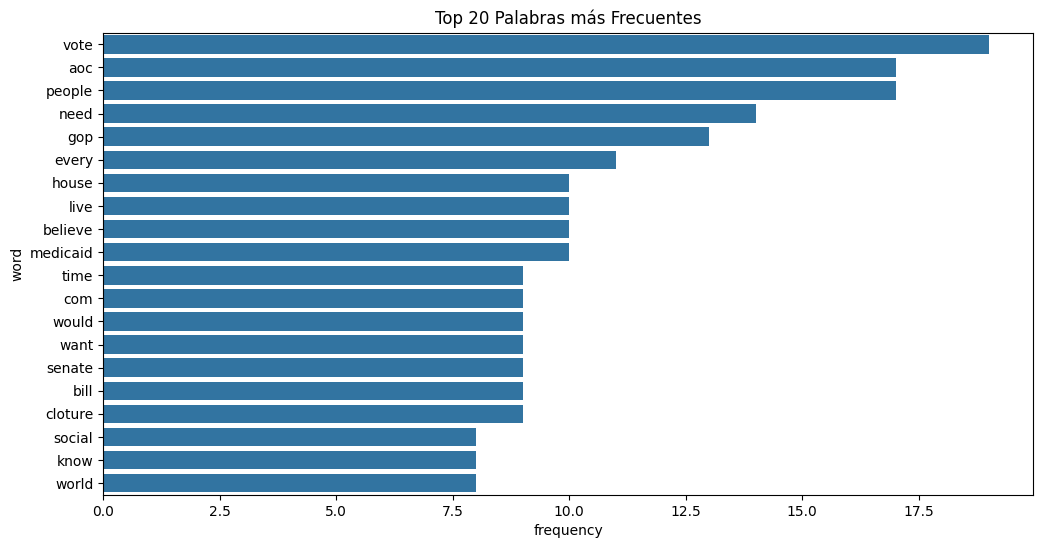


Frecuencia de palabras:


,word,frequency
0,vote,19
1,aoc,17
2,people,17
3,need,14
4,gop,13
5,every,11
6,house,10
7,live,10
8,believe,10
9,medicaid,10


In [56]:
# Nueva celda para análisis de texto
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Descargar todos los recursos necesarios de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

def analyze_text(text_series):
    # Convertir a minúsculas y unir todos los textos
    all_text = ' '.join(text_series.str.lower())
    
    # Limpiar el texto de caracteres especiales y números
    all_text = re.sub(r'[^\w\s]', ' ', all_text)
    
    # Tokenizar el texto (usando un método más simple)
    tokens = all_text.split()
    
    # Eliminar stopwords y palabras cortas
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    
    # Contar frecuencia de palabras
    word_freq = Counter(filtered_tokens)
    
    # Crear DataFrame con las palabras más frecuentes
    df_word_freq = pd.DataFrame(word_freq.most_common(20), columns=['word', 'frequency'])
    
    # Visualizar las palabras más frecuentes
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df_word_freq, x='frequency', y='word')
    plt.title('Top 20 Palabras más Frecuentes')
    plt.show()
    
    return df_word_freq

# Aplicar análisis al texto de los posts
word_frequency_df = analyze_text(df['text'])
print("\nFrecuencia de palabras:")
display(word_frequency_df)

## Análisis recomendado por el LLM de Cursos, a modo complementario al anterior

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\FSONZOGNI\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!



Estadísticas de Longitud de Posts:
       text_length  word_count
count    99.000000   99.000000
mean    178.555556   31.090909
std      97.827965   17.011455
min       9.000000    2.000000
25%      98.000000   18.000000
50%     175.000000   31.000000
75%     278.500000   47.500000
max     301.000000   58.000000


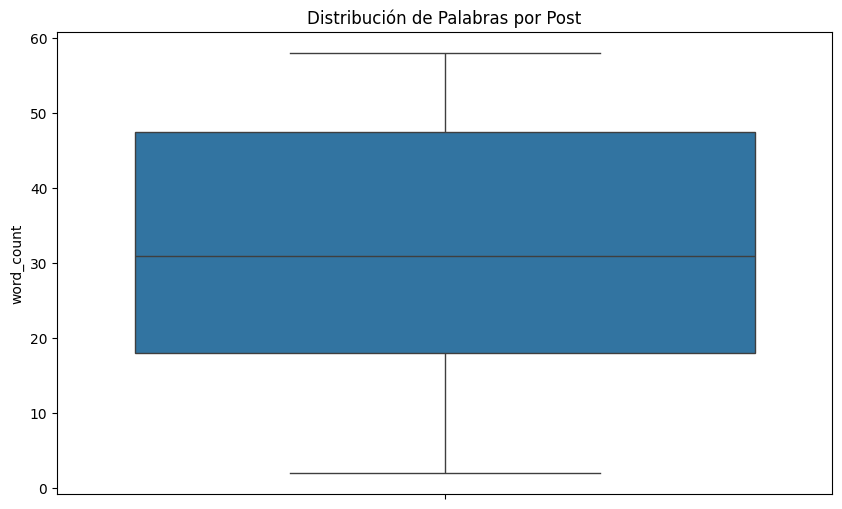

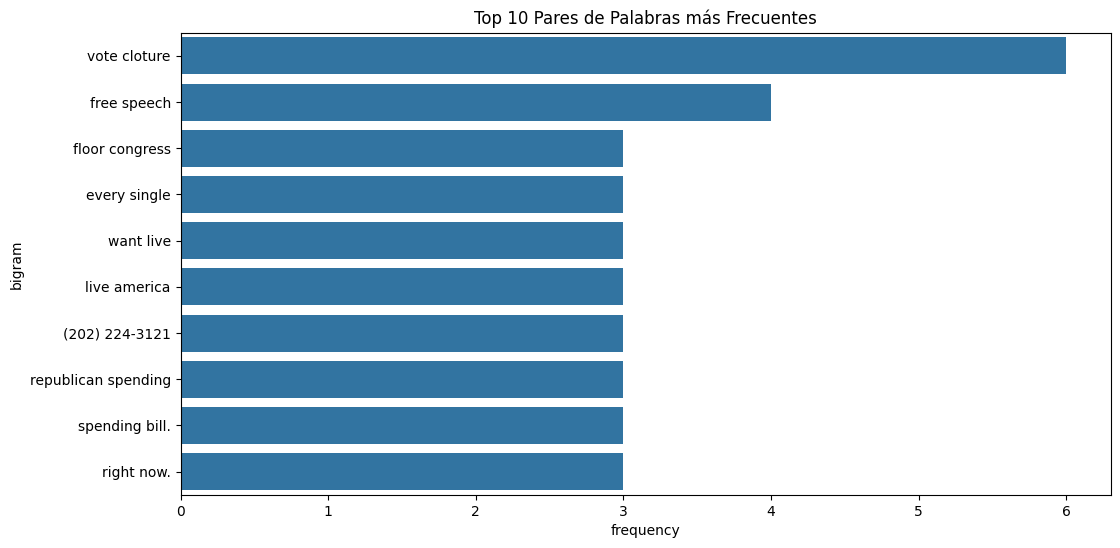

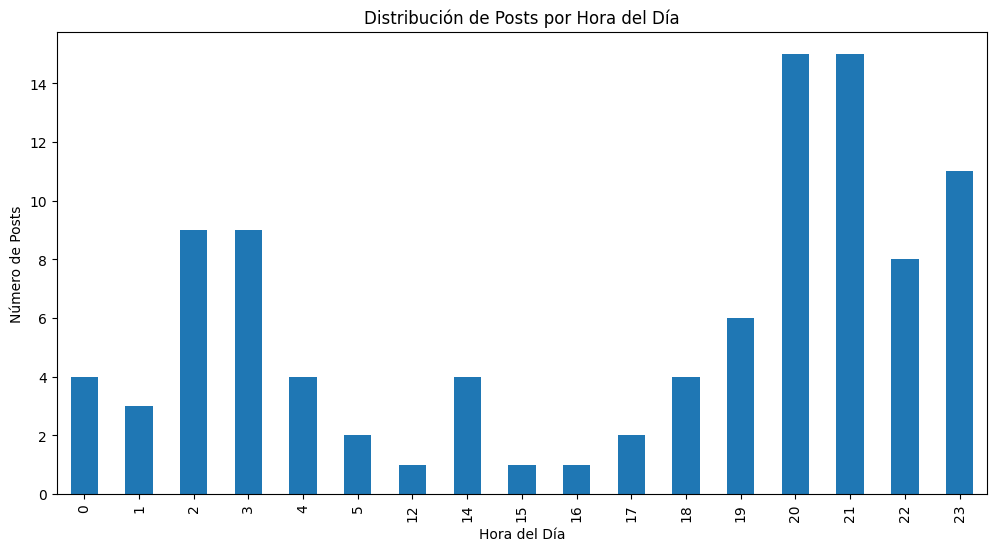


Hashtags más frecuentes:
[('#saveourservices', 1)]

Menciones más frecuentes:
[('@aoc', 5), ('@chrismurphyct', 1), ('@jaketapper', 1)]


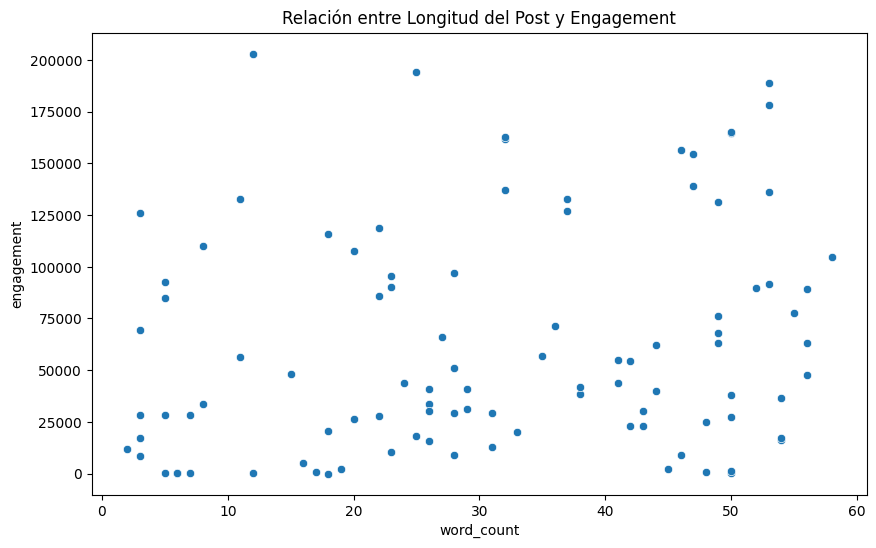


Palabras más frecuentes en posts de alto engagement:
[('people', 11), ('need', 10), ('every', 8), ('want', 8), ('vote', 8), ('believe', 7), ('it’s', 7), ('now.', 6), ('dem', 6), ('gop', 6)]

Palabras más frecuentes en posts de bajo engagement:
[('vote', 9), ('gop', 6), ('trying', 5), ('would', 5), ('don’t', 5), ('may', 5), ('doge', 4), ('like', 4), ('going', 4), ('house', 4)]


In [57]:
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import re
from datetime import datetime
import numpy as np

# Descargar recursos adicionales
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

def analyze_text_patterns(text_series):
    # 1. Análisis de Longitud de Posts
    df['text_length'] = df['text'].str.len()
    df['word_count'] = df['text'].str.split().str.len()
    
    print("\nEstadísticas de Longitud de Posts:")
    print(df[['text_length', 'word_count']].describe())
    
    # Visualización de longitud de posts
    plt.figure(figsize=(10, 6))
    sns.boxplot(y=df['word_count'])
    plt.title('Distribución de Palabras por Post')
    plt.show()
    
    # 2. Análisis de Bigramas (pares de palabras frecuentes)
    all_text = ' '.join(text_series.str.lower())
    words = all_text.split()
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words and len(word) > 2]
    bigrams = list(ngrams(words, 2))
    bigram_freq = Counter(bigrams)
    
    # Visualizar bigramas más frecuentes
    plt.figure(figsize=(12, 6))
    bigram_df = pd.DataFrame(bigram_freq.most_common(10), columns=['bigram', 'frequency'])
    bigram_df['bigram'] = bigram_df['bigram'].apply(lambda x: ' '.join(x))
    sns.barplot(data=bigram_df, x='frequency', y='bigram')
    plt.title('Top 10 Pares de Palabras más Frecuentes')
    plt.show()
    
    # 3. Análisis Temporal
    df['hour'] = df['created_at'].dt.hour
    hourly_posts = df.groupby('hour').size()
    
    plt.figure(figsize=(12, 6))
    hourly_posts.plot(kind='bar')
    plt.title('Distribución de Posts por Hora del Día')
    plt.xlabel('Hora del Día')
    plt.ylabel('Número de Posts')
    plt.show()
    
    # 4. Análisis de Hashtags y Menciones
    hashtags = re.findall(r'#\w+', all_text)
    mentions = re.findall(r'@\w+', all_text)
    
    print("\nHashtags más frecuentes:")
    print(Counter(hashtags).most_common(5))
    print("\nMenciones más frecuentes:")
    print(Counter(mentions).most_common(5))
    
    # 5. Análisis de Engagement
    df['engagement'] = df['likes'] + df['reposts'] + df['replies']
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='word_count', y='engagement')
    plt.title('Relación entre Longitud del Post y Engagement')
    plt.show()
    
    # 6. Análisis de Palabras Clave por Engagement
    high_engagement_posts = df[df['engagement'] > df['engagement'].median()]
    low_engagement_posts = df[df['engagement'] <= df['engagement'].median()]
    
    def get_top_words(posts, n=10):
        words = ' '.join(posts['text'].str.lower()).split()
        words = [word for word in words if word not in stop_words and len(word) > 2]
        return Counter(words).most_common(n)
    
    print("\nPalabras más frecuentes en posts de alto engagement:")
    print(get_top_words(high_engagement_posts))
    print("\nPalabras más frecuentes en posts de bajo engagement:")
    print(get_top_words(low_engagement_posts))
    
    return df

# Aplicar análisis
df = analyze_text_patterns(df['text'])

## Análisis de sentimiento

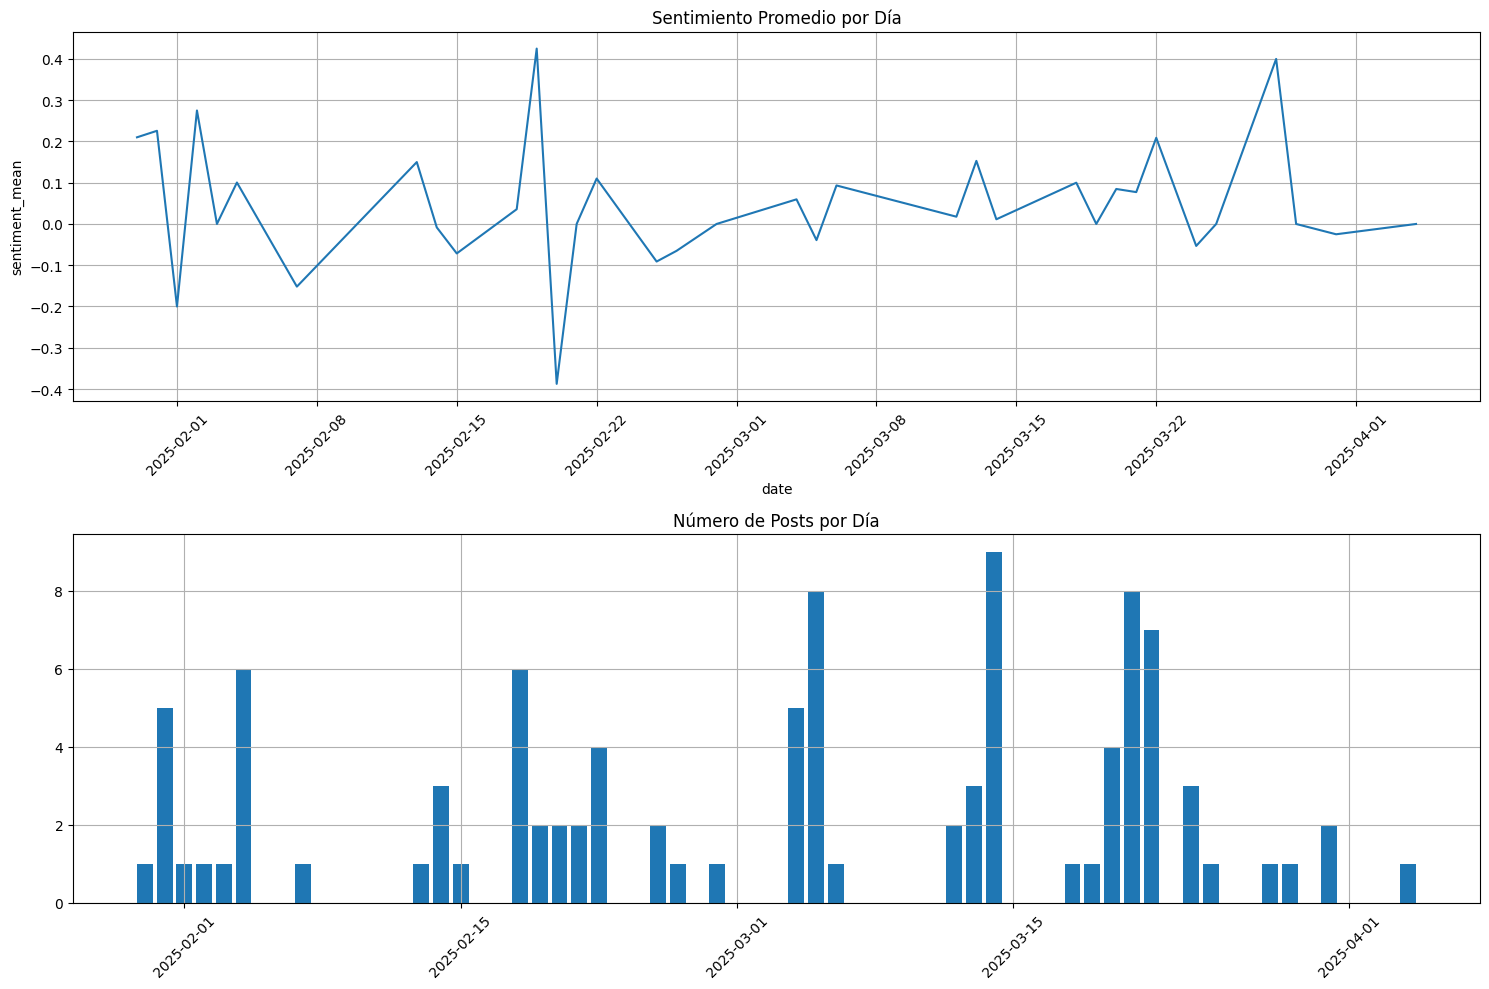


Estadísticas de Sentimiento por Día:
      date  sentiment_mean  post_count
2025-01-30        0.210000           1
2025-01-31        0.225796           5
2025-02-01       -0.200000           1
2025-02-02        0.275000           1
2025-02-03        0.000000           1
2025-02-04        0.100469           6
2025-02-07       -0.151852           1
2025-02-13        0.150000           1
2025-02-14       -0.008333           3
2025-02-15       -0.071429           1
2025-02-18        0.035734           6
2025-02-19        0.425000           2
2025-02-20       -0.387500           2
2025-02-21        0.000000           2
2025-02-22        0.110069           4
2025-02-25       -0.091071           2
2025-02-26       -0.065079           1
2025-02-28        0.000000           1
2025-03-04        0.059673           5
2025-03-05       -0.039149           8
2025-03-06        0.093333           1
2025-03-12        0.017619           2
2025-03-13        0.152879           3
2025-03-14        0.011332

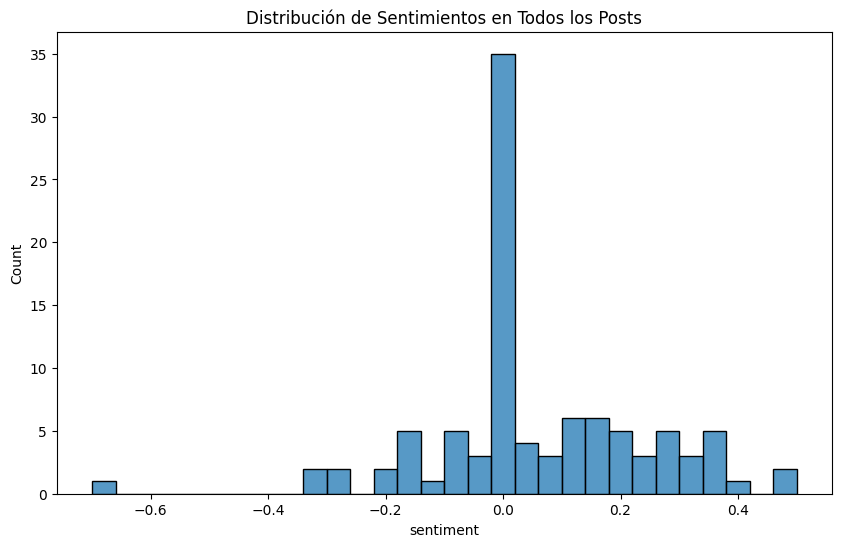


Estadísticas Generales de Sentimiento:
Sentimiento promedio general: 0.058
Posts positivos (>0.1): 35
Posts negativos (<-0.1): 13
Posts neutrales (-0.1 a 0.1): 51


In [58]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates

def analyze_sentiment_by_day(df):
    # Convertir created_at a fecha (sin hora)
    df['date'] = df['created_at'].dt.date
    
    # Función para calcular el sentimiento
    def get_sentiment(text):
        try:
            return TextBlob(str(text)).sentiment.polarity
        except:
            return 0
    
    # Calcular sentimiento para cada post
    df['sentiment'] = df['text'].apply(get_sentiment)
    
    # Agrupar por fecha y calcular estadísticas
    daily_sentiment = df.groupby('date').agg({
        'sentiment': ['mean', 'count'],
        'text': lambda x: ' '.join(x)  # Unir todos los textos del día
    }).reset_index()
    
    # Renombrar columnas
    daily_sentiment.columns = ['date', 'sentiment_mean', 'post_count', 'daily_text']
    
    # Calcular sentimiento promedio del día
    daily_sentiment['daily_sentiment'] = daily_sentiment['daily_text'].apply(get_sentiment)
    
    # Crear visualizaciones
    plt.figure(figsize=(15, 10))
    
    # Gráfico 1: Sentimiento promedio por día
    plt.subplot(2, 1, 1)
    ax1 = plt.gca()
    sns.lineplot(data=daily_sentiment, x='date', y='sentiment_mean')
    plt.title('Sentimiento Promedio por Día')
    
    # Formatear el eje X para mostrar fechas correctamente
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    plt.grid(True)
    
    # Gráfico 2: Número de posts por día
    plt.subplot(2, 1, 2)
    ax2 = plt.gca()
    
    # Convertir fechas a formato matplotlib
    dates = mdates.date2num(daily_sentiment['date'])
    
    # Crear el gráfico de barras con fechas
    plt.bar(dates, daily_sentiment['post_count'])
    
    # Formatear el eje X para mostrar fechas correctamente
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.title('Número de Posts por Día')
    plt.xticks(rotation=45)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Mostrar estadísticas
    print("\nEstadísticas de Sentimiento por Día:")
    print(daily_sentiment[['date', 'sentiment_mean', 'post_count']].to_string(index=False))
    
    # Análisis adicional: Distribución de sentimientos
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='sentiment', bins=30)
    plt.title('Distribución de Sentimientos en Todos los Posts')
    plt.show()
    
    # Calcular estadísticas generales
    print("\nEstadísticas Generales de Sentimiento:")
    print(f"Sentimiento promedio general: {df['sentiment'].mean():.3f}")
    print(f"Posts positivos (>0.1): {len(df[df['sentiment'] > 0.1])}")
    print(f"Posts negativos (<-0.1): {len(df[df['sentiment'] < -0.1])}")
    print(f"Posts neutrales (-0.1 a 0.1): {len(df[(df['sentiment'] >= -0.1) & (df['sentiment'] <= 0.1)])}")
    
    return daily_sentiment

# Aplicar el análisis
daily_sentiment_df = analyze_sentiment_by_day(df)

## Genera CSV con el análisis de sentimiento por día

In [59]:
# --- Celda Final: Interpretación y Exportación de Sentimiento Diario a CSV ---
import numpy as np
import pandas as pd

# Asegúrate que daily_sentiment_df existe y no está vacío
if 'daily_sentiment_df' in locals() and not daily_sentiment_df.empty:

    print("Interpretando resultados de sentimiento diario...")

    # Definir umbrales para la interpretación
    POSITIVE_THRESHOLD = 0.05 # Sentimiento > 0.05 se considera Positivo
    NEGATIVE_THRESHOLD = -0.05 # Sentimiento < -0.05 se considera Negativo
                               # Entre -0.05 y 0.05 (inclusive) se considera Neutral

    # Crear la columna de interpretación basada en 'sentiment_mean'
    conditions = [
        daily_sentiment_df['sentiment_mean'] > POSITIVE_THRESHOLD,
        daily_sentiment_df['sentiment_mean'] < NEGATIVE_THRESHOLD
    ]
    choices = ['Positivo', 'Negativo']
    # np.select es eficiente para esto
    daily_sentiment_df['sentiment_label'] = np.select(conditions, choices, default='Neutral')

    # Seleccionar y renombrar columnas para el CSV
    df_export = daily_sentiment_df[['date', 'sentiment_mean', 'sentiment_label']].copy()
    df_export.rename(columns={'sentiment_mean': 'sentimiento_promedio',
                              'sentiment_label': 'interpretacion'}, inplace=True)

    # Definir nombre del archivo CSV
    csv_filename = 'analisis_sentimiento_diario.csv'

    # Exportar a CSV
    try:
        df_export.to_csv(csv_filename, index=False, encoding='utf-8-sig') # utf-8-sig para mejor compatibilidad con Excel
        print(f"\n✅ Análisis de sentimiento diario exportado exitosamente a: '{csv_filename}'")
        print("   El archivo contiene las columnas: date, sentimiento_promedio, interpretacion")

        # Mostrar vista previa de los datos exportados
        print("\nVista previa de los datos en el CSV:")
        display(df_export.head())

    except Exception as e:
        print(f"\n❌ Error al exportar a CSV: {e}")

else:
    print("⚠️ No se encontró el DataFrame 'daily_sentiment_df' o está vacío. Ejecuta la celda de análisis de sentimiento primero.")


Interpretando resultados de sentimiento diario...

✅ Análisis de sentimiento diario exportado exitosamente a: 'analisis_sentimiento_diario.csv'
   El archivo contiene las columnas: date, sentimiento_promedio, interpretacion

Vista previa de los datos en el CSV:


,date,sentimiento_promedio,interpretacion
0,2025-01-30,0.210000,Positivo
1,2025-01-31,0.225796,Positivo
2,2025-02-01,-0.200000,Negativo
3,2025-02-02,0.275000,Positivo
4,2025-02-03,0.000000,Neutral


## Análisis de sentimiento por librería "vaderSentiment"

Ejecutando análisis de sentimiento VADER sobre los posts FILTRADOS...
Calculando sentimiento VADER para cada post...
Cálculo de sentimiento individual completado.
Agrupando resultados por día...
Agrupación completada.
Generando visualizaciones...


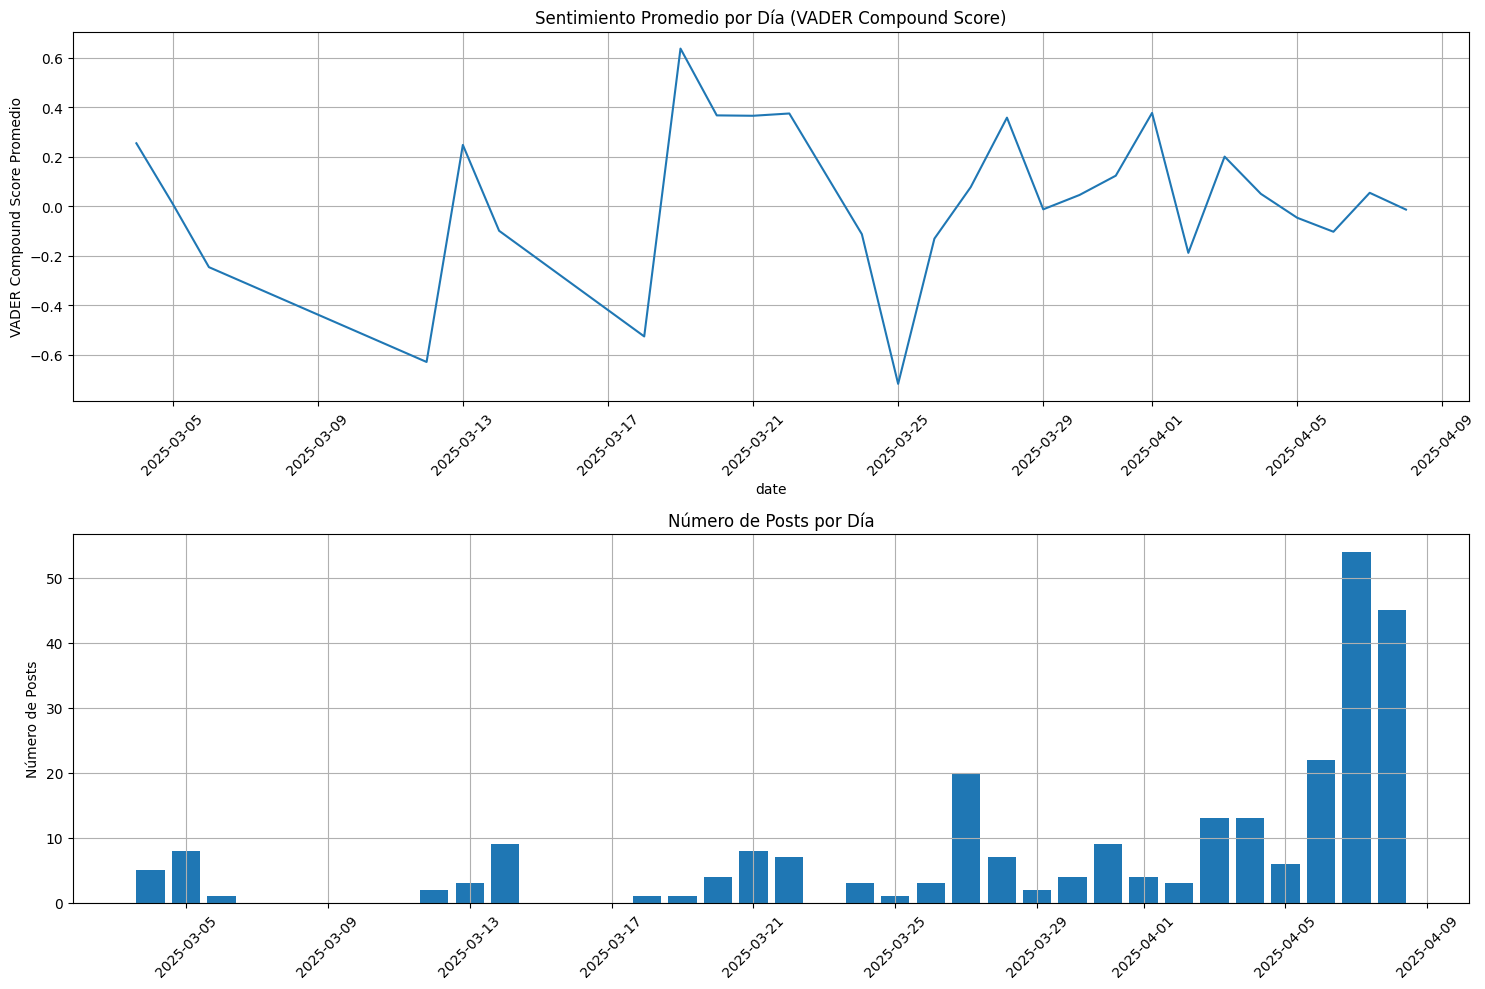

Visualizaciones generadas.

Estadísticas de Sentimiento por Día (VADER):
      date  sentiment_mean  post_count
2025-03-04        0.254140           5
2025-03-05        0.009938           8
2025-03-06       -0.246600           1
2025-03-12       -0.629950           2
2025-03-13        0.247533           3
2025-03-14       -0.099656           9
2025-03-18       -0.526700           1
2025-03-19        0.636900           1
2025-03-20        0.366900           4
2025-03-21        0.365350           8
2025-03-22        0.374571           7
2025-03-24       -0.113333           3
2025-03-25       -0.718400           1
2025-03-26       -0.131300           3
2025-03-27        0.076725          20
2025-03-28        0.357757           7
2025-03-29       -0.012900           2
2025-03-30        0.045125           4
2025-03-31        0.123111           9
2025-04-01        0.376775           4
2025-04-02       -0.188800           3
2025-04-03        0.200154          13
2025-04-04        0.049715    

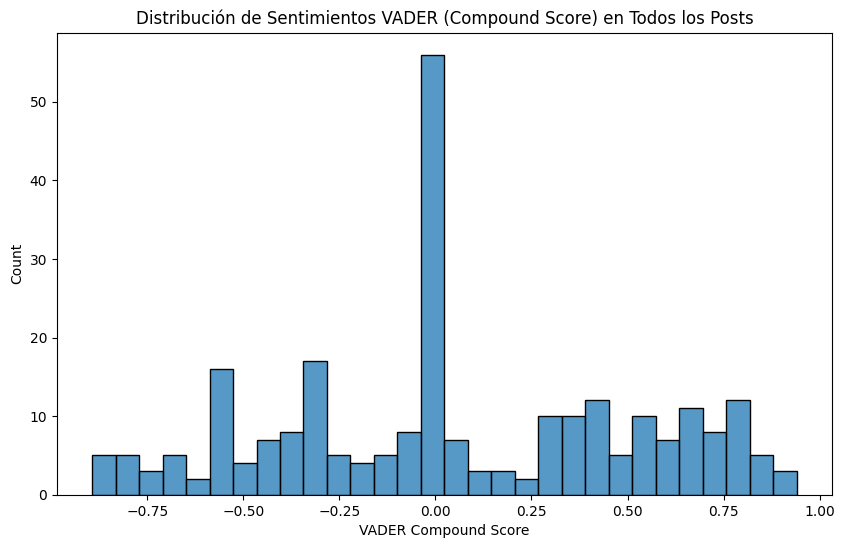


Estadísticas Generales de Sentimiento VADER:
Sentimiento VADER promedio general: 0.057
Posts positivos (VADER >= 0.05): 106
Posts negativos (VADER <= -0.05): 94
Posts neutrales (VADER >-0.05 y <0.05): 58


In [60]:
# --- Celda de Análisis de Sentimiento Diario (con VADER) ---
# Descomenta y ejecuta si no tienes vaderSentiment instalado
# !pip install vaderSentiment

!pip install vaderSentiment 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import matplotlib.dates as mdates
import pandas as pd # Asegúrate que pandas está importado

# Función para analizar sentimiento diario usando VADER
def analyze_sentiment_by_day_vader(df_input):
    # Crear una copia para evitar modificar el DataFrame original directamente
    df = df_input.copy()

    # Inicializar el analizador VADER
    analyzer = SentimentIntensityAnalyzer()

    # Convertir created_at a fecha (sin hora) si no lo está ya
    if 'date' not in df.columns:
         # Asegurarse que created_at existe y es datetime
         if 'created_at' not in df.columns or not pd.api.types.is_datetime64_any_dtype(df['created_at']):
             print("Error: La columna 'created_at' no existe o no es de tipo datetime.")
             return pd.DataFrame() # Devuelve DataFrame vacío en caso de error
         df['date'] = df['created_at'].dt.date

    # Función para calcular el sentimiento VADER (usando 'compound' score)
    def get_vader_sentiment(text):
        try:
            # Obtener el 'compound' score que resume el sentimiento (-1 a +1)
            vs = analyzer.polarity_scores(str(text))
            return vs['compound']
        except:
            return 0 # Devuelve 0 si hay algún error

    # Calcular sentimiento VADER para cada post
    print("Calculando sentimiento VADER para cada post...")
    df['sentiment'] = df['text'].apply(get_vader_sentiment)
    print("Cálculo de sentimiento individual completado.")

    # Agrupar por fecha y calcular estadísticas
    print("Agrupando resultados por día...")
    daily_sentiment = df.groupby('date').agg(
        # Usamos mean para el promedio de scores 'compound' del día
        sentiment_mean=('sentiment', 'mean'),
        post_count=('sentiment', 'size') # size es más directo para contar filas
    ).reset_index()
    print("Agrupación completada.")

    # --- Visualizaciones ---
    print("Generando visualizaciones...")
    plt.figure(figsize=(15, 10))

    # Gráfico 1: Sentimiento promedio (VADER compound) por día
    plt.subplot(2, 1, 1)
    ax1 = plt.gca()
    sns.lineplot(data=daily_sentiment, x='date', y='sentiment_mean')
    plt.title('Sentimiento Promedio por Día (VADER Compound Score)')
    plt.ylabel('VADER Compound Score Promedio')
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    plt.grid(True)

    # Gráfico 2: Número de posts por día
    plt.subplot(2, 1, 2)
    ax2 = plt.gca()
    # Convertir fechas a formato matplotlib para plt.bar
    try:
        dates_num = mdates.date2num(daily_sentiment['date'])
        plt.bar(dates_num, daily_sentiment['post_count'])
    except Exception as e:
        print(f"Error al graficar barras de posts por día: {e}. Intentando con seaborn...")
        # Fallback a seaborn si hay problemas con la conversión de fechas para bar
        sns.barplot(data=daily_sentiment, x='date', y='post_count', ax=ax2)

    plt.title('Número de Posts por Día')
    plt.ylabel('Número de Posts')
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax2.xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    print("Visualizaciones generadas.")

    # --- Estadísticas y Distribución ---
    print("\nEstadísticas de Sentimiento por Día (VADER):")
    # Asegurar que la columna de fecha se muestra bien
    daily_sentiment_display = daily_sentiment[['date', 'sentiment_mean', 'post_count']].copy()
    daily_sentiment_display['date'] = pd.to_datetime(daily_sentiment_display['date']).dt.strftime('%Y-%m-%d')
    print(daily_sentiment_display.to_string(index=False))

    # Análisis adicional: Distribución de sentimientos VADER
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='sentiment', bins=30)
    plt.title('Distribución de Sentimientos VADER (Compound Score) en Todos los Posts')
    plt.xlabel('VADER Compound Score')
    plt.show()

    # Calcular estadísticas generales VADER (usando los mismos umbrales para comparar)
    print("\nEstadísticas Generales de Sentimiento VADER:")
    print(f"Sentimiento VADER promedio general: {df['sentiment'].mean():.3f}")
    # Umbrales VADER estándar: Positive >= 0.05, Negative <= -0.05, Neutral >-0.05 and <0.05
    positive_vader_count = len(df[df['sentiment'] >= 0.05])
    negative_vader_count = len(df[df['sentiment'] <= -0.05])
    neutral_vader_count = len(df[(df['sentiment'] > -0.05) & (df['sentiment'] < 0.05)])
    print(f"Posts positivos (VADER >= 0.05): {positive_vader_count}")
    print(f"Posts negativos (VADER <= -0.05): {negative_vader_count}")
    print(f"Posts neutrales (VADER >-0.05 y <0.05): {neutral_vader_count}")

    return daily_sentiment # Devolvemos el DataFrame agrupado por día

# --- EJECUCIÓN ---
# Decidir qué DataFrame usar para el análisis:
# Si ejecutaste la celda de filtrado y df_filtered existe y no está vacío:
if 'df_filtered' in locals() and isinstance(df_filtered, pd.DataFrame) and not df_filtered.empty:
    print("Ejecutando análisis de sentimiento VADER sobre los posts FILTRADOS...")
    daily_sentiment_df_vader = analyze_sentiment_by_day_vader(df_filtered)
# Si no, usar el DataFrame original 'df'
elif 'df' in locals() and isinstance(df, pd.DataFrame) and not df.empty:
    print("Ejecutando análisis de sentimiento VADER sobre TODOS los posts...")
    daily_sentiment_df_vader = analyze_sentiment_by_day_vader(df)
else:
    print("⚠️ Error: No se encontró un DataFrame 'df' o 'df_filtered' válido para analizar.")
    daily_sentiment_df_vader = pd.DataFrame() # Crear df vacío para evitar errores posteriores


## Genera CSV por método de VADER

In [61]:
# --- Celda Final: Interpretación y Exportación de Sentimiento Diario a CSV (VADER) ---
import numpy as np
import pandas as pd

# Asegúrate que daily_sentiment_df_vader existe y no está vacío
if 'daily_sentiment_df_vader' in locals() and not daily_sentiment_df_vader.empty:

    print("Interpretando resultados de sentimiento VADER diario...")

    # Definir umbrales para la interpretación VADER
    POSITIVE_THRESHOLD = 0.05  # Sentimiento > 0.05 se considera Positivo
    NEGATIVE_THRESHOLD = -0.05 # Sentimiento < -0.05 se considera Negativo
                               # Entre -0.05 y 0.05 (inclusive) se considera Neutral

    # Crear la columna de interpretación basada en 'sentiment_mean'
    conditions = [
        daily_sentiment_df_vader['sentiment_mean'] > POSITIVE_THRESHOLD,
        daily_sentiment_df_vader['sentiment_mean'] < NEGATIVE_THRESHOLD
    ]
    choices = ['Positivo', 'Negativo']
    # np.select es eficiente para esto
    daily_sentiment_df_vader['sentiment_label'] = np.select(conditions, choices, default='Neutral')

    # Seleccionar y renombrar columnas para el CSV
    df_export = daily_sentiment_df_vader[['date', 'sentiment_mean', 'sentiment_label', 'post_count']].copy()
    df_export.rename(columns={
        'sentiment_mean': 'sentimiento_promedio',
        'sentiment_label': 'interpretacion',
        'post_count': 'numero_posts'
    }, inplace=True)

    # Formatear la fecha para mejor legibilidad en el CSV
    df_export['date'] = pd.to_datetime(df_export['date']).dt.strftime('%Y-%m-%d')

    # Definir nombre del archivo CSV
    csv_filename = 'analisis_sentimiento_vader_diario.csv'

    # Exportar a CSV
    try:
        df_export.to_csv(csv_filename, index=False, encoding='utf-8-sig') # utf-8-sig para mejor compatibilidad con Excel
        print(f"\n✅ Análisis de sentimiento VADER diario exportado exitosamente a: '{csv_filename}'")
        print("   El archivo contiene las columnas:")
        print("   - date: Fecha del análisis")
        print("   - sentimiento_promedio: Score VADER promedio del día (-1 a +1)")
        print("   - interpretacion: Clasificación del sentimiento (Positivo/Negativo/Neutral)")
        print("   - numero_posts: Cantidad de posts analizados ese día")

        # Mostrar vista previa de los datos exportados
        print("\nVista previa de los datos en el CSV:")
        display(df_export.head())

        # Mostrar estadísticas resumidas
        print("\nResumen de interpretaciones:")
        sentiment_counts = df_export['interpretacion'].value_counts()
        for sentiment, count in sentiment_counts.items():
            print(f"   - {sentiment}: {count} días")

    except Exception as e:
        print(f"\n❌ Error al exportar a CSV: {e}")

else:
    print("⚠️ No se encontró el DataFrame 'daily_sentiment_df_vader' o está vacío. Ejecuta la celda de análisis de sentimiento VADER primero.")

Interpretando resultados de sentimiento VADER diario...

✅ Análisis de sentimiento VADER diario exportado exitosamente a: 'analisis_sentimiento_vader_diario.csv'
   El archivo contiene las columnas:
   - date: Fecha del análisis
   - sentimiento_promedio: Score VADER promedio del día (-1 a +1)
   - interpretacion: Clasificación del sentimiento (Positivo/Negativo/Neutral)
   - numero_posts: Cantidad de posts analizados ese día

Vista previa de los datos en el CSV:


,date,sentimiento_promedio,interpretacion,numero_posts
0,2025-03-04,0.254140,Positivo,5
1,2025-03-05,0.009938,Neutral,8
2,2025-03-06,-0.246600,Negativo,1
3,2025-03-12,-0.629950,Negativo,2
4,2025-03-13,0.247533,Positivo,3



Resumen de interpretaciones:
   - Positivo: 12 días
   - Negativo: 9 días
   - Neutral: 6 días
